In [1]:
# For this project I'll tackle the Fashion MNIST dataset. A 70,000 grayscale image set of 28 x 28
# pixels, repesented in 10 classes. Each images represent fashion items however, and thus more
# challenging. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]


In [20]:
X_train.shape

(55000, 28, 28)

In [4]:
X_valid.shape

(5000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
# Let's us try to scale them. 

X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
 "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [8]:
class_names[y_train[0]]

'Ankle boot'

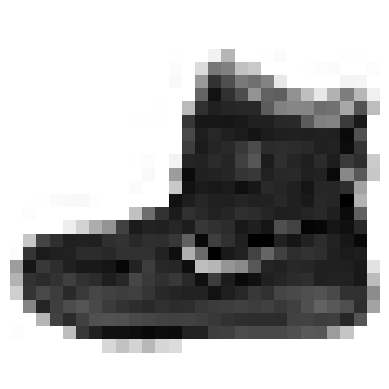

In [9]:
# showing an image of the clothing

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

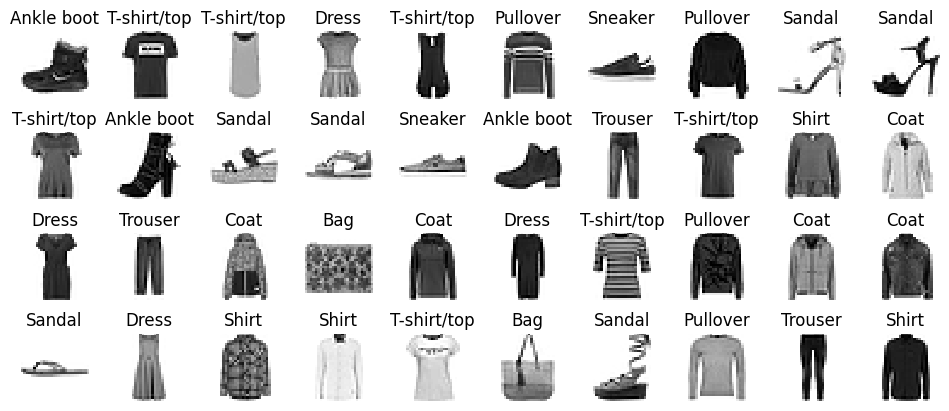

In [11]:
# gives a visualization of the classes of garments

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

In [12]:
# Let us try using a RadomForestClassifier on this. 

# Flatten our 28x28 images into 784-length vectors

X_train_flat = X_train.reshape(-1, 784)
X_valid_flat = X_valid.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

In [13]:
# Let us use Variance Threshold to remove features with no variance, i.e no weight

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_train_sel = selector.fit_transform(X_train_flat)
X_valid_sel = selector.transform(X_valid_flat)
X_test_sel = selector.transform(X_test_flat)

In [14]:
# Let's use PCA to reduce dimensionality, keeping 95% of the variance
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_sel)
X_valid_pca = pca.transform(X_valid_sel)
X_test_pca = pca.transform(X_test_sel)

In [15]:
# Testing the Classifier

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_pca, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [16]:
from sklearn.metrics import accuracy_score

y_pred = rf_clf.predict(X_valid_pca)
print("Accuracy:", accuracy_score(y_valid, y_pred))

Accuracy: 0.8626


In [17]:
y_pred = rf_clf.predict(X_test_pca)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8562


In [18]:
# Let's finetune the RandomForest using RandomSearch
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 100),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_pca, y_train)
print("Best from Random Search:", random_search.best_params_)

Best from Random Search: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 91}


In [19]:
rand_bestmodel = random_search.best_estimator_

y_pred = rand_bestmodel.predict(X_valid_pca)
print("Accuracy:", accuracy_score(y_valid, y_pred))


Accuracy: 0.862


In [21]:
# Let us try and solve the fashion mnist dta set by using pretrained layers.
# We will train a part of the dataset, then retrain it again and check the accuracy

# Split the Fashion MNIST dataset into tasks A and B, then train and save the model 
# to "my_model_A"

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [22]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_std = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [29]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

In [30]:
def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

# We split the data set using our split_dataset func nto DB's. One excluding pos_class &
# neg_class. The other one being just those two datasets. 

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [31]:
tf.random.set_seed(42)

# Building our first model 
model_A = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
               metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                     validation_data=(X_valid_A, y_valid_A))

model_A.save("my_model_A.keras")

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4916 - loss: 1.4946 - val_accuracy: 0.7689 - val_loss: 0.7229
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7799 - loss: 0.6748 - val_accuracy: 0.8280 - val_loss: 0.5467
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8328 - loss: 0.5309 - val_accuracy: 0.8513 - val_loss: 0.4664
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8540 - loss: 0.4569 - val_accuracy: 0.8651 - val_loss: 0.4189
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8661 - loss: 0.4110 - val_accuracy: 0.8709 - val_loss: 0.3883
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8736 - loss: 0.3804 - val_accuracy: 0.8739 - val_loss: 0.3671
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8807 - loss: 0.3586 - val_accuracy: 0.8759 - val_loss: 0.3516
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8865 - loss:

In [32]:
# Now we will try and train just class_B to see the accuracy

tf.random.set_seed(42)

model_B = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu",
                         kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                         kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                         kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
               metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                     validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.7334 - loss: 0.6056 - val_accuracy: 0.7587 - val_loss: 0.5919
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7748 - loss: 0.5785 - val_accuracy: 0.8111 - val_loss: 0.5693
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8003 - loss: 0.5561 - val_accuracy: 0.8368 - val_loss: 0.5507
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8414 - loss: 0.5373 - val_accuracy: 0.8556 - val_loss: 0.5346
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8517 - loss: 0.5207 - val_accuracy: 0.8615 - val_loss: 0.5205
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8864 - loss: 0.5062 - val_accuracy: 0.8724 - val_loss: 0.5078
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8842 - loss: 0.4930 - val_accuracy: 0.8783 - val_loss: 0.4961
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9108 - loss: 0.4810 - val_accuracy: 0.8813 - val_loss: 0.4852

[0.3993273973464966, 0.9125000238418579]

In [35]:
tf.random.set_seed(42)

In [37]:
# Now we load model_A again and add it to a new model which we will call again later

model_A = tf.keras.models.load_model("my_model_A.keras")

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))


In [40]:
# first freeze all the reused layers, compile and train

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                    metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                          validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.3567 - loss: 0.7820 - val_accuracy: 0.3848 - val_loss: 0.7622
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3718 - loss: 0.7652 - val_accuracy: 0.4045 - val_loss: 0.7479
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4018 - loss: 0.7495 - val_accuracy: 0.4303 - val_loss: 0.7341
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4186 - loss: 0.7345 - val_accuracy: 0.4560 - val_loss: 0.7208


In [41]:
# Unfreeze, compile and retrain again

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                    metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                          validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.4715 - loss: 0.7068 - val_accuracy: 0.6034 - val_loss: 0.6493
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6295 - loss: 0.6372 - val_accuracy: 0.7141 - val_loss: 0.5930
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7379 - loss: 0.5802 - val_accuracy: 0.8051 - val_loss: 0.5482
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8326 - loss: 0.5341 - val_accuracy: 0.8605 - val_loss: 0.5107
Epoch 5/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8755 - loss: 0.4943 - val_accuracy: 0.8813 - val_loss: 0.4783
Epoch 6/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.8878 - loss: 0.4599 - val_accuracy: 0.8882 - val_loss: 0.4502
Epoch 7/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8928 - loss: 0.4296 - val_accuracy: 0.8991 - val_loss: 0.4251
Epoch 8/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9152 - loss: 0.4024 - val_accuracy: 0.9149 - val_loss: 0

In [42]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9218 - loss: 0.3003


[0.3095856308937073, 0.9204999804496765]

In [43]:
# So now our binary model has an accuracy of 92% as opposed to 91% it has before. 

1 - (100 - 92.18) / (100 - 91.25)

0.1062857142857151

In [49]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
# Now we will try using Batch Normalization and Dropout to try and perfect our multiclassifier

model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics=['accuracy'])

# Using OneCycleLR Callback

def one_cycle_schedule(epoch, total_epochs=25, max_lr=0.03, base_lr=0.003):
    if epoch < total_epochs // 2:
        lr = base_lr + (max_lr - base_lr) * (epoch / (total_epochs // 2))
    else:
        lr = max_lr - (max_lr - base_lr) * ((epoch - total_epochs // 2) / ( total_epochs // 2))
    return lr

total_epochs = 25
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: one_cycle_schedule(epoch, total_epochs=total_epochs))


history = model.fit(X_train, y_train,
                   epochs=total_epochs,
                   validation_data=(X_valid, y_valid),
                   callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7077 - loss: 0.8578 - val_accuracy: 0.8418 - val_loss: 0.4327 - learning_rate: 0.0030
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8180 - loss: 0.5089 - val_accuracy: 0.8592 - val_loss: 0.3824 - learning_rate: 0.0052
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8388 - loss: 0.4559 - val_accuracy: 0.8582 - val_loss: 0.3866 - learning_rate: 0.0075
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8470 - loss: 0.4250 - val_accuracy: 0.8498 - val_loss: 0.4199 - learning_rate: 0.0098
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8547 - loss: 0.4050 - val_accuracy: 0.8630 - val_loss: 0.3790 - learning_rate: 0.0120
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8633 - loss: 0.3855 - val_accuracy: 0.8632 - val_loss: 0.3679 - learning_rate: 0.0143
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accura

In [52]:
# Let's try and train for a bit longer, no scheduler and a lower learning_rate

model.optimizer.learning_rate = 0.001

fine_tune_history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid)
)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9273 - loss: 0.1942 - val_accuracy: 0.8994 - val_loss: 0.3034
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9280 - loss: 0.1914 - val_accuracy: 0.8984 - val_loss: 0.3076
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9281 - loss: 0.1898 - val_accuracy: 0.8990 - val_loss: 0.3070
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9291 - loss: 0.1911 - val_accuracy: 0.8980 - val_loss: 0.3101
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9281 - loss: 0.1894 - val_accuracy: 0.8982 - val_loss: 0.3083
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9288 - loss: 0.1895 - val_accuracy: 0.8984 - val_loss: 0.3074
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9298 - loss: 0.1855 - val_accuracy: 0.8996 - val_loss: 0.3079
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9282 -

In [53]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8923 - loss: 0.3426


[0.33346930146217346, 0.8944000005722046]